# Plotting Spectra 
This python notebook is going to outline how to load a fits file containing a spectra and preform basic manipulation and fitting of the data 

In [1]:
#We will need several notebooks
import matplotlib.pyplot as plt #used to plot the spectra
import numpy as np #very useful for manipulating arrays
from astropy.io import fits #used to import fits files

**Flexible Image Transport System (FITS)** is an open standard defining a digital file format useful for storage, transmission and processing of data: formatted as multi-dimensional arrays (for example a 2D image), or tables.

This is the standard way in which images and spectra are stored in astronomy. The FITS file format has a header which contains useful information about the data including when the observation occured, what time the observation occured, what telescope was used for the observation, ect. The second part is the data. The data can be in many formats including a simple 2D array (an image) or a cube. 

In [4]:
#Our first step will be to open the FITS file. You were provided a spectrum of the Sun. The file is titled 884752_melchiors_spectrum.fits
# The data is from Melchiors which is a library of science ready high-resolution spectra. https://www.royer.se/melchiors.html
hdul = fits.open('884752_melchiors_spectrum.fits')
#this will print the information that is displayed in the FITS file.
hdul.info()

Filename: 884752_melchiors_spectrum.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  FLUX          1 PrimaryHDU     189   ()      
  1                1 BinTableHDU     70   167788R x 10C   [E, E, E, E, E, E, E, E, E, E]   


In [9]:
#next you need to investigate the headers so you can learn about what format the spectra is being presented in.
#execute the next line. It will print the entire header in the first hdu
#note that python uses zero indexing meaning the first instance of something is zero not 1
print(repr(hdul[0].header))

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2023-01-09T10:18:34' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
ORIGIN  = 'Instituut voor Sterrenkunde, KU Leuven' / Institution                
OBSERVAT= 'LaPalma '           / Observatory name                               
TELESCOP= 'Mercator'           / Telescope name                                 
OBSGEO-X=         5327306.5552 / Cartesian X [meters] GRS80                     
OBSGEO-Y=        -1718448.6952 / Cartesian Y [meters] GRS80                     
OBSGEO-Z=         3051947.77

In [8]:
#Lets now look at the next header which has even more information
#this header is associated with the data as the data for this FITS file is storred in the second HDU 
#. (which is 1 with python zero indexing)

#note that there are 7 rows of information, TTYPE# is saying what is in each element of the list. 
#. We want to use the normalized flux
print(repr(hdul[1].header))

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   40 / length of dimension 1                          
NAXIS2  =               167788 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   10 / number of table fields                         
TTYPE1  = 'wave_log'                                                            
TFORM1  = 'E       '                                                            
TTYPE2  = 'wave    '                                                            
TFORM2  = 'E       '                                                            
TTYPE3  = 'flux_norm'       

In [10]:
spectrum_list = hdul[1].data #import all of the data
#for some reason they put the data in the format of a numpy array that contians lists. Which is very difficult to plot
# there is almost certainly a way to plot this better, but this is what I did.
#create a numpy array that is three by the length of the spectrum
norm_flux = np.zeros((3,len(spectrum_list)))

#do a for loop over the length of the spectrum that puts the wavelength, normalized spectrum, and uncertainty into
# a useful numpy array
for i in range(0,len(spectrum_list)):
    norm_flux[0,i] = spectrum_list[i][1]
    norm_flux[1,i] = spectrum_list[i][2]
    norm_flux[2,i] = spectrum_list[i][3]

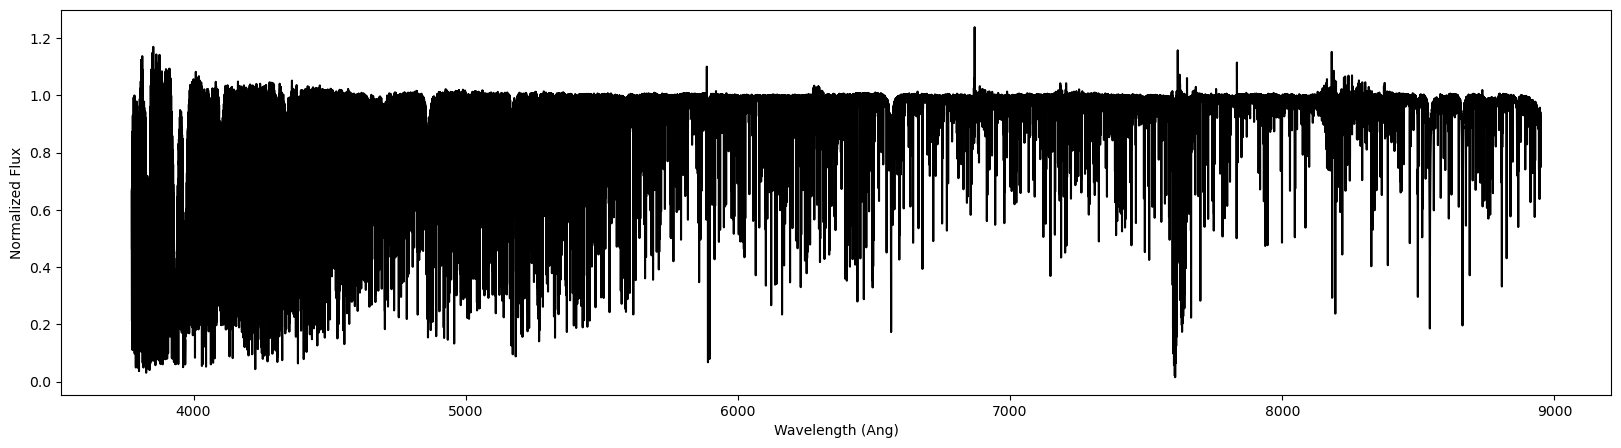

In [19]:
#plot the entire spectrum
fig, ax = plt.subplots(figsize=(20, 5)) #make the image wide to make it easier to see the spectrum
plt.plot(norm_flux[0],norm_flux[1],'-',color='k')
plt.xlabel('Wavelength (Ang)')
plt.ylabel('Normalized Flux')
plt.show()
plt.close()

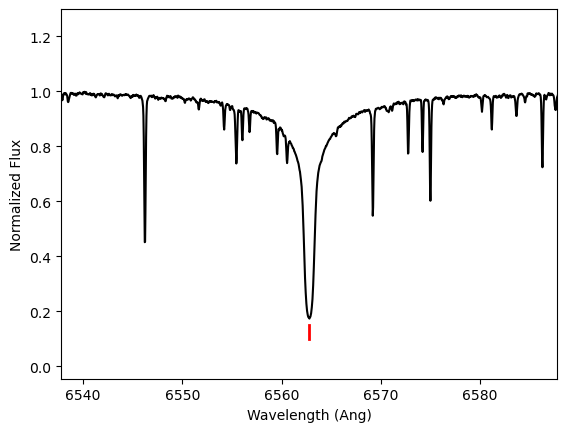

In [20]:
#plot the entire spectrum
halpha_lam = 6562.81 #halpha 

plt.plot(norm_flux[0],norm_flux[1],'-',color='k')
plt.xlabel('Wavelength (Ang)')
plt.ylabel('Normalized Flux')
plt.xlim(halpha_lam - 25, halpha_lam + 25)
plt.plot((halpha_lam, halpha_lam), (0.1,0.15),'-',color='r',lw=2) #draw a read line where H-alpha is located
plt.show()
plt.close()

In [21]:
#identify the following lines and create plots for them
#Hbeta 4861.34 ang
#Calcium H line (Ca+) = 3968.47
#Calcium K line (Ca+) = 3933.66
#Fe = 5270.39

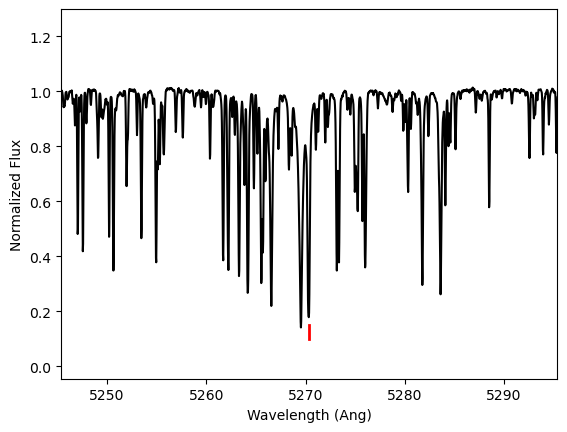

In [44]:
line = 5270.39 #halpha 

plt.plot(norm_flux[0],norm_flux[1],'-',color='k')
plt.xlabel('Wavelength (Ang)')
plt.ylabel('Normalized Flux')
plt.xlim(line - 25, line + 25)
#plt.ylim(0.8,1.15)
plt.plot((line, line), (0.1,0.15),'-',color='r',lw=2) #draw a read line where the specified line is is located
plt.show()
plt.close()

In [55]:
#Our ultimate goal is to measure the abundances of a star. We are going to start with something like the Sun.
#Our first step is to measure the EW of the spectral lines.

#define the functions that we might need
from scipy.special import wofz
#Voigt function
def voigt(x, x0, A, sigma, gamma):
    """
    Computes the Voigt line profile.

    Parameters
    ----------
    x : array_like
        The independent variable.
    sigma : float
        The standard deviation of the Gaussian component.
    gamma : float
        The HWHM of the Lorentzian component.

    Returns
    -------
    array_like
        The Voigt profile.
    """
    z = (((x-x0) + 1j * gamma) / (sigma * np.sqrt(2)))
    return 1 - A*np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi))

#Gaussian Function
def gaussian (x, x0, A, sigma):
  return 1 - A*np.exp(-(x-x0)**2/(2*sigma**2))

#Lorentzian function
def lorentzian (x, x0, A, gamma):
  return 1 - A*gamma**2/(np.pi*gamma**2 + ((x-x0)**2))


#gaussian area
def gaussian_area(A,sigma):
    return A*np.sqrt(np.pi*2)*sigma

[6.77230210e+03 3.01650452e-01 6.73397631e-02] [0.00123712 0.00489696 0.00125215]
Gaussian EW (ang):  0.050917315523670126
[ 6.77230148e+03  1.02750020e+00 -3.65746653e-02] [0.00230433 0.03697091 0.00187374]
[6.77235106e+03 2.40653068e-01 4.10907945e-06 7.59717972e-01] [ 0.53716599  0.58174833 69.05875984  2.00332444]


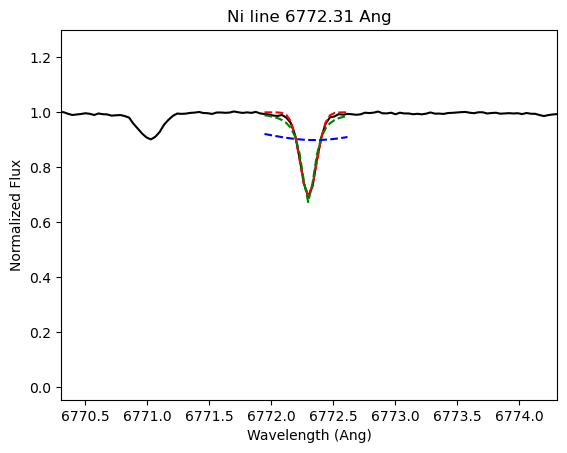

In [67]:
line = 6772.31 #halpha
width = 10

a = np.argmin(np.abs(norm_flux[0,:]-line))

# prompt: fit gaussian to data
from scipy.optimize import curve_fit

popt, pcov = curve_fit(gaussian, norm_flux[0,a-width:a+width], 
                       norm_flux[1,a-width:a+width], sigma=norm_flux[2,a-width:a+width], 
                       p0=[line, 0.4, 2], bounds=(0,[np.inf,1.0,np.inf]))
perr = np.sqrt(np.diag(pcov))
print(popt, perr)

output = gaussian (norm_flux[0,a-width:a+width], popt[0], popt[1], popt[2])

print('Gaussian EW (ang): ',gaussian_area(popt[1],popt[2]))

popt, pcov = curve_fit(lorentzian, norm_flux[0,a-width:a+width], 
                       norm_flux[1,a-width:a+width], sigma=norm_flux[2,a-width:a+width], 
                       p0=[line, 0.4, 2])
perr = np.sqrt(np.diag(pcov))
print(popt, perr)

l_output = lorentzian(norm_flux[0,a-width:a+width], popt[0], popt[1], popt[2])

popt, pcov = curve_fit(voigt, norm_flux[0,a-width:a+width], 
                       norm_flux[1,a-width:a+width], sigma=norm_flux[2,a-width:a+width], 
                       p0=[line, 0.4, 2,2])
perr = np.sqrt(np.diag(pcov))
print(popt, perr)

v_output = voigt(norm_flux[0,a-width:a+width], popt[0], popt[1], popt[2],popt[3])

plt.plot(norm_flux[0], norm_flux[1], '-', color='k')
plt.plot(norm_flux[0,a-width:a+width], output, '--', color='r')
plt.plot(norm_flux[0,a-width:a+width], l_output, '--', color='g')
plt.plot(norm_flux[0,a-width:a+width], v_output, '--', color='b')
plt.plot((halpha_lam, halpha_lam), (0.1,0.15),'-',color='r',lw=2) #draw a read line where H-alpha is located
plt.xlabel('Wavelength (Ang)')
plt.ylabel('Normalized Flux')
plt.title('Ni line ' + str(line) + ' Ang')
plt.xlim(line-2,line+2)
#plt.ylim(0.3,1.05)
plt.savefig('Ni_line_' + str(line) + '_Ang.png', dpi=300)
plt.show()
plt.close()

In [53]:
#spectral lines
#6597.56 Fe
#6627.54 Fe 
#6646.93 Fe 
#6653.91 Fe 
#6677.99 Fe 
#6703.57 Fe 
#6710.32 Fe 
#6725.36 Fe 
#6726.67 Fe 
#6733.15 Fe 
#6806.86 Fe 
#6810.27 Fe 
#6820.37 Fe 
#6717.68 Ca 
#6721.85 Si 
#6643.63 Ni 
#6767.77 Ni 
#6772.31 Ni


0.3990434422338111
